In [1]:
import os
import glob
base_dir = os.path.join('F:/0Sem 7/B.TECH PROJECT/0Image data/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
print("Infected samples:",len(infected_files))
print("Uninfected samples:",len(healthy_files))

Infected samples: 13779
Uninfected samples: 13779


In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,F:/0Sem 7/B.TECH PROJECT/0Image data/cell_imag...,malaria
1,F:/0Sem 7/B.TECH PROJECT/0Image data/cell_imag...,malaria
2,F:/0Sem 7/B.TECH PROJECT/0Image data/cell_imag...,healthy
3,F:/0Sem 7/B.TECH PROJECT/0Image data/cell_imag...,healthy
4,F:/0Sem 7/B.TECH PROJECT/0Image data/cell_imag...,healthy


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [4]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_14: working on img num: 5000
ThreadPoolExecutor-0_1: working on img num: 10000
ThreadPoolExecutor-0_15: working on img num: 15000
ThreadPoolExecutor-0_8: working on img num: 17360
Min Dimensions: [46 49  3]
Avg Dimensions: [132.89856575 132.50751685   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


In [5]:
IMG_DIMS = (32, 32)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_16: working on img num: 5000
ThreadPoolExecutor-1_5: working on img num: 10000
ThreadPoolExecutor-1_17: working on img num: 15000
ThreadPoolExecutor-1_15: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_9: working on img num: 0
ThreadPoolExecutor-1_17: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_15: working on img num: 0
ThreadPoolExecutor-1_15: working on img num: 5000
ThreadPoolExecutor-1_12: working on img num: 8267


((17361, 32, 32, 3), (1929, 32, 32, 3), (8268, 32, 32, 3))

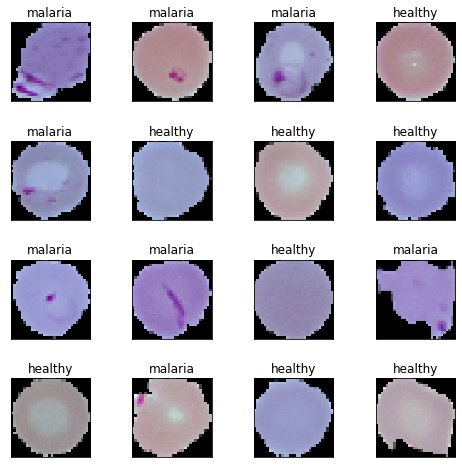

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [7]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (32, 32, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [8]:
import tensorflow as tf

In [9]:
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

restnet = applications.resnet.ResNet50(weights= None, include_top=False, input_shape= INPUT_SHAPE)

#out = restnet.layers[-1].output
#outt = Flatten()(out)
#restnet = Model(restnet.input, outputs=outt)

restnet.trainable=True

#set_trainable=False
#for layer in restnet.layers:
#    if layer.name in ['res5c_branch2b', 'res5c_branch2c']:
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False

for layer in restnet.layers:
    layer.trainable=True

layers = [(layer, layer.name, layer.trainable) for layer in restnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,True
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,True
3,<tensorflow.python.keras.layers.normalization....,conv1_bn,True
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,True
...,...,...,...
170,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_2_relu,True
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization....,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True


In [10]:
restnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
base_resnet = restnet
base_out = base_resnet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_resnet.input, outputs=out)

In [12]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
"""
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)
"""

"\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dropout(0.7)(x)\npredictions = Dense(num_classes, activation= 'sigmoid')(x)\nmodel = Model(inputs = base_model.input, outputs = predictions)\n"

In [14]:
"""
from keras.optimizers import Adam
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
"""

"\nfrom keras.optimizers import Adam\nadam = Adam(lr=0.0001)\nmodel.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])\n"

In [15]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 83s 5ms/sample - loss: 0.6345 - accuracy: 0.6693 - val_loss: 1.3536 - val_accuracy: 0.5588
Epoch 2/25
17361/17361 [==============================] - 56s 3ms/sample - loss: 0.4744 - accuracy: 0.7513 - val_loss: 0.5377 - val_accuracy: 0.7398
Epoch 3/25
17361/17361 [==============================] - 56s 3ms/sample - loss: 0.3425 - accuracy: 0.8439 - val_loss: 2.3490 - val_accuracy: 0.5029
Epoch 4/25
17361/17361 [==============================] - 56s 3ms/sample - loss: 0.2687 - accuracy: 0.8879 - val_loss: 0.2932 - val_accuracy: 0.9160
Epoch 5/25
17361/17361 [==============================] - 57s 3ms/sample - loss: 0.2211 - accuracy: 0.9137 - val_loss: 3.5128 - val_accuracy: 0.4971
Epoch 6/25
17361/17361 [==============================] - 57s 3ms/sample - loss: 0.1868 - accuracy: 0.9292 - val_loss: 0.3801 - val_accuracy: 0.8450
Epoch 7/25
17361/17361 [==============================] -

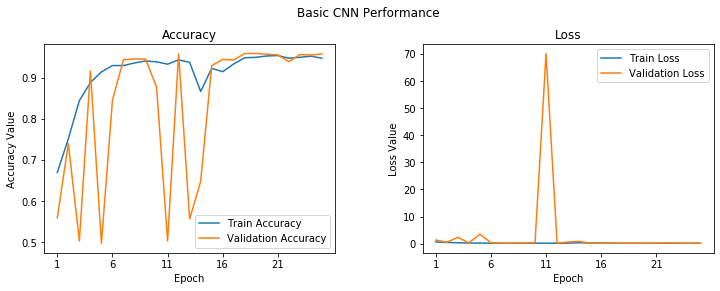

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
test_imgs_scaled = test_data/255.
test_labels_enc = le.transform(test_labels)

# evaluate the model
_, train_acc = model.evaluate(train_imgs_scaled, train_labels_enc, verbose=0)
_, test_acc = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.954, Test: 0.952


In [19]:
model.save('ResNet95.2.h5')

In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________